In [1]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

Using TensorFlow backend.


> Loading data... 
> Data Loaded. Compiling...
> Compilation Time :  0.03786444664001465
Train on 3523 samples, validate on 186 samples
Epoch 1/160
3523/3523 [==============================] - 6s - loss: 0.0023 - val_loss: 8.5786e-04
Epoch 2/160
3523/3523 [==============================] - 1s - loss: 7.7942e-04 - val_loss: 5.9064e-04
Epoch 3/160
3523/3523 [==============================] - 1s - loss: 6.7288e-04 - val_loss: 6.4364e-04
Epoch 4/160
3523/3523 [==============================] - 1s - loss: 6.0763e-04 - val_loss: 5.6087e-04
Epoch 5/160
3523/3523 [==============================] - 1s - loss: 5.5604e-04 - val_loss: 6.0052e-04
Epoch 6/160
3523/3523 [==============================] - 1s - loss: 5.2324e-04 - val_loss: 4.0613e-04
Epoch 7/160
3523/3523 [==============================] - 1s - loss: 5.8460e-04 - val_loss: 4.0684e-04
Epoch 8/160
3523/3523 [==============================] - 1s - loss: 4.4870e-04 - val_loss: 4.1612e-04
Epoch 9/160
3523/3523 [=============================

3523/3523 [==============================] - 1s - loss: 1.9860e-04 - val_loss: 1.6848e-04
Epoch 80/160
3523/3523 [==============================] - 1s - loss: 2.0468e-04 - val_loss: 2.8350e-04
Epoch 81/160
3523/3523 [==============================] - 1s - loss: 2.3246e-04 - val_loss: 1.6079e-04
Epoch 82/160
3523/3523 [==============================] - 1s - loss: 2.2033e-04 - val_loss: 1.7944e-04
Epoch 83/160
3523/3523 [==============================] - 1s - loss: 2.2107e-04 - val_loss: 1.7240e-04
Epoch 84/160
3523/3523 [==============================] - 1s - loss: 2.0269e-04 - val_loss: 2.5186e-04
Epoch 85/160
3523/3523 [==============================] - 1s - loss: 2.2139e-04 - val_loss: 1.5691e-04
Epoch 86/160
3523/3523 [==============================] - 1s - loss: 1.9729e-04 - val_loss: 1.4780e-04
Epoch 87/160
3523/3523 [==============================] - 1s - loss: 2.3358e-04 - val_loss: 1.5488e-04
Epoch 88/160
3523/3523 [==============================] - 1s - loss: 2.0673e-04 - val_

3523/3523 [==============================] - 1s - loss: 2.1095e-04 - val_loss: 1.5496e-04
Epoch 159/160
3523/3523 [==============================] - 1s - loss: 1.7920e-04 - val_loss: 1.6459e-04
Epoch 160/160
3523/3523 [==============================] - 1s - loss: 2.0042e-04 - val_loss: 1.5511e-04
Training duration (s) :  335.00907254219055


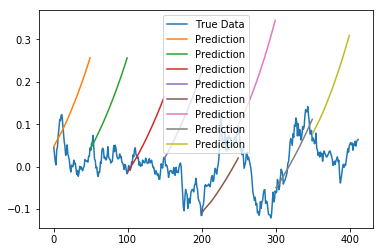

In [2]:
import time
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

global_start_time = time.time()
epochs  = 160
seq_len = 50

print('> Loading data... ')

X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)

print('> Data Loaded. Compiling...')

model = build_model([1, 50, 100, 1])

board = TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=500, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=epochs,
    validation_split=0.05, callbacks=[board])



predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)
#predicted = lstm.predict_point_by_point(model, X_test)        

print('Training duration (s) : ', time.time() - global_start_time)
plot_results_multiple(predictions, y_test, 50)